<h1><center>Deep Learning : Assignment 05 part-b</h1>
<h1><center>MSCS18030 - Muhammad Rauf Tabassam</h1>

#Objectives
In part-2 of assignment 5, you will be performing multi-class, multi-label classification. You are required to implement focal loss for detecting infections such as COVID-19 among X-Ray images: 

1. Use CNN, pre-trained on ImageNet, to extract basic features from X-Ray images.
2. Train the classification layers in order to detect instances of Infected (COVID-19 + Pneumonia) and Normal X-Ray images.
3. Fine-tune the entire network to try to improve performance.
4. Implement focal loss


## Task 1: Finetune pre-trained CNN models
* In this task you will fine-tune two networks (ResNet-18 and VGG-16) pretrained on ImageNet weights.
* Load these models in PyTorch.
* Replace all FC layers with a fully connected network of your choice. You are free to choose the number of layers and neurons per layer.
* Finetune the model using CrossEntropy loss. Please note that default cross-entropy loss of PyTorch has a built-in Softmax. For this assignment you will not be needing softmax. So instead, use BCEWithLogitsLoss (link). This loss accepts one-hot vectors for targets. This loss automatically applies a sigmoid function.
* Now write a function for Focal Loss and use this loss instead of the Negative Log Likelihood loss for finetuning the model.
* You can also download part-1 codes of your class fellows from Github. Search for DLSpring2020 in the Github search bar. You must cite the repository if you are doing so.
* Save your model and name it as ‘vgg16_focal_loss.pth’ and ‘res18_focal_loss.pth’

Main experiments for Github are:
1. One experiment of ResNet-18 and VGG-16 each, end-to-end without focal loss
2. One experiment of ResNet-18 and VGG-16 each, end-to-end with focal loss


In [1]:
from google.colab import drive
drive.mount("./drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
!unzip '/content/drive/My Drive/Copy of A_05_Part_02_Dataset.zip' #-d '/content/drive/My Drive/DL_A5b_data'

In [0]:
data_dir = '/content/A_05_Part_02_Dataset'

In [50]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(25),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test2', transform=test_transforms)

print("train_data: ", len(train_data))
print("validation_data: ", len(validation_data))
print("test_data: ", len(test_data))

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)


train_data:  6200
validation_data:  628
test_data:  629
Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


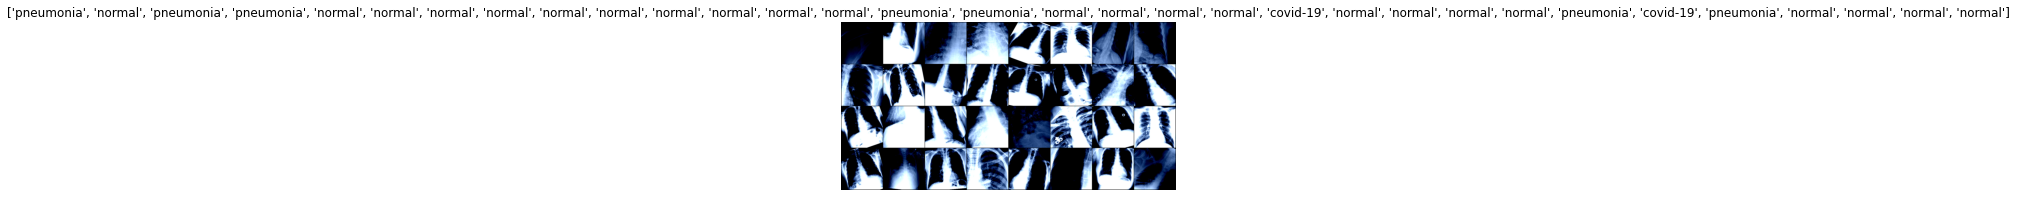

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def Accuracy(model,loader):
    model = model.to(device)
    correct = 0
    total = 0
    lbls = []
    pred = []
    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            images, labels = images.to(device), one_hot(labels).to(device)
            outputs = model(images)
            predicted = torch.sigmoid(outputs.data)
            for i in range(len(predicted)):
                for j in range(len(predicted[i])):
                    if predicted[i][j] >= 0.5:
                        predicted[i][j] = 1
                    else:
                        predicted[i][j] = 0
            total += labels.size(0)
            for i in range(labels.size(0)):
                if(str(predicted[i]) == str(labels[i])):
                    correct += 1
            lbls.extend(labels.tolist())
            pred.extend(predicted.tolist())
    return correct/total, lbls, pred

def one_hot(label):
    one_h = torch.zeros(len(label),3)
    for i in range(len(label)):
        if label[i] == 0:
            one_h[i][0] = 1
            one_h[i][1] = 1
        elif label[i] == 1:
            one_h[i][1] = 1
        elif label[i] == 2:
            one_h[i][2] = 1
    return one_h

# Task 1: Load pretrained CNN model and fine-tune FC Layers

## ResNet18

### Loading pre-trained RES18

In [8]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)
num_features = res18.fc.in_features
fc_features = []
fc_features.append(nn.Linear(num_features,256))
fc_features.append(nn.ReLU(inplace=True))
fc_features.append(nn.Dropout())
fc_features.append(nn.Linear(256,128))
fc_features.append(nn.ReLU(inplace=True))
fc_features.append(nn.Dropout())
fc_features.append(nn.Linear(128, len(class_names)))

res18.fc = nn.Sequential(*fc_features)
print(res18)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
res18.requires_grad = True

### Loss function and optimizer

In [0]:
Epochs = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9) #, weight_decay=1e-5) #https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20

### Training

In [11]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
res18.to(device)

res18.train()
train_loss = []
train_accu = []
validation_loss = []
validation_accu = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    # inp = input("Press 'N' to stop, anykey to continue!")
    # if inp == 'N':
    #     break
    #training
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = res18.forward(inputs)     #----> forward pass
        oh_labels = one_hot(labels).to(device)
        loss = criterion(outputs, oh_labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_loss.append(running_loss)
    train_accu.append(Accuracy(res18,trainloader)[0])
    print("Training Accuracy:",train_accu[-1])
    #torch.save(res18.state_dict(), str(epoch)+'res18_without_focal_loss.pth')
    
    #validation loss
    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() 
        outputs = res18.forward(inputs)     #----> forward pass
        oh_labels = one_hot(labels).to(device)
        loss = criterion(outputs, oh_labels)   #----> compute loss

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    validation_loss.append(running_loss) 
    validation_accu.append(Accuracy(res18,validationloader)[0])
    print("Validation Accuracy:",validation_accu[-1])
    
print('Finished Training')

device: cuda:0


Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.424157: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:44<00:00,  1.86it/s]

Training Accuracy: 0.6429032258064517



Validation Epoch: 0 [380/628 (95%)]	Loss: 0.319392: : 20it [00:08,  2.34it/s]
100%|██████████| 20/20 [00:09<00:00,  2.17it/s]

Validation Accuracy: 0.6337579617834395



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.460673: : 194it [01:41,  1.92it/s]
100%|██████████| 194/194 [01:44<00:00,  1.86it/s]

Training Accuracy: 0.675



Validation Epoch: 1 [380/628 (95%)]	Loss: 0.264813: : 20it [00:08,  2.33it/s]
100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

Validation Accuracy: 0.695859872611465



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.430731: : 194it [01:42,  1.90it/s]
100%|██████████| 194/194 [01:45<00:00,  1.85it/s]


Training Accuracy: 0.8062903225806451


Validation Epoch: 2 [380/628 (95%)]	Loss: 0.397844: : 20it [00:08,  2.29it/s]
100%|██████████| 20/20 [00:09<00:00,  2.16it/s]

Validation Accuracy: 0.8232484076433121



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.281655: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:45<00:00,  1.83it/s]

Training Accuracy: 0.8479032258064516



Validation Epoch: 3 [380/628 (95%)]	Loss: 0.245809: : 20it [00:08,  2.27it/s]
100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

Validation Accuracy: 0.8694267515923567



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.275374: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]

Training Accuracy: 0.8579032258064516



Validation Epoch: 4 [380/628 (95%)]	Loss: 0.254048: : 20it [00:08,  2.28it/s]
100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

Validation Accuracy: 0.8726114649681529



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.148204: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]


Training Accuracy: 0.86


Validation Epoch: 5 [380/628 (95%)]	Loss: 0.262778: : 20it [00:08,  2.31it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.8742038216560509



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.186642: : 194it [01:42,  1.88it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]

Training Accuracy: 0.863225806451613



Validation Epoch: 6 [380/628 (95%)]	Loss: 0.227926: : 20it [00:08,  2.29it/s]
100%|██████████| 20/20 [00:09<00:00,  2.15it/s]

Validation Accuracy: 0.8853503184713376



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.325080: : 194it [01:43,  1.88it/s]
100%|██████████| 194/194 [01:46<00:00,  1.82it/s]

Training Accuracy: 0.8670967741935484



Validation Epoch: 7 [380/628 (95%)]	Loss: 0.180679: : 20it [00:08,  2.28it/s]
100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

Validation Accuracy: 0.893312101910828



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.138624: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]

Training Accuracy: 0.8767741935483871



Validation Epoch: 8 [380/628 (95%)]	Loss: 0.244673: : 20it [00:08,  2.27it/s]
100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

Validation Accuracy: 0.8996815286624203



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.480984: : 194it [01:43,  1.88it/s]
100%|██████████| 194/194 [01:43<00:00,  1.87it/s]

Training Accuracy: 0.8767741935483871



Validation Epoch: 9 [380/628 (95%)]	Loss: 0.188502: : 20it [00:08,  2.33it/s]
100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

Validation Accuracy: 0.8901273885350318



Train Epoch: 10 [4632/6200 (99%)]	Loss: 0.194197: : 194it [01:40,  1.93it/s]
100%|██████████| 194/194 [01:43<00:00,  1.88it/s]

Training Accuracy: 0.8816129032258064



Validation Epoch: 10 [380/628 (95%)]	Loss: 0.247848: : 20it [00:08,  2.32it/s]
100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

Validation Accuracy: 0.8980891719745223



Train Epoch: 11 [4632/6200 (99%)]	Loss: 0.113315: : 194it [01:40,  1.93it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]

Training Accuracy: 0.8785483870967742



Validation Epoch: 11 [380/628 (95%)]	Loss: 0.170902: : 20it [00:08,  2.32it/s]
100%|██████████| 20/20 [00:09<00:00,  2.20it/s]

Validation Accuracy: 0.8980891719745223



Train Epoch: 12 [4632/6200 (99%)]	Loss: 0.154269: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:45<00:00,  1.85it/s]

Training Accuracy: 0.8788709677419355



Validation Epoch: 12 [380/628 (95%)]	Loss: 0.044915: : 20it [00:08,  2.25it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.8949044585987261



Train Epoch: 13 [4632/6200 (99%)]	Loss: 0.230351: : 194it [01:42,  1.90it/s]
100%|██████████| 194/194 [01:44<00:00,  1.85it/s]

Training Accuracy: 0.8859677419354839



Validation Epoch: 13 [380/628 (95%)]	Loss: 0.287576: : 20it [00:08,  2.34it/s]
100%|██████████| 20/20 [00:09<00:00,  2.17it/s]

Validation Accuracy: 0.8996815286624203



Train Epoch: 14 [4632/6200 (99%)]	Loss: 0.319341: : 194it [01:41,  1.90it/s]
100%|██████████| 194/194 [01:45<00:00,  1.83it/s]

Training Accuracy: 0.8816129032258064



Validation Epoch: 14 [380/628 (95%)]	Loss: 0.323196: : 20it [00:08,  2.29it/s]
100%|██████████| 20/20 [00:09<00:00,  2.15it/s]

Validation Accuracy: 0.9076433121019108



Train Epoch: 15 [4632/6200 (99%)]	Loss: 0.186716: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]

Training Accuracy: 0.8832258064516129



Validation Epoch: 15 [380/628 (95%)]	Loss: 0.092355: : 20it [00:08,  2.23it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.89171974522293



Train Epoch: 16 [4632/6200 (99%)]	Loss: 0.340299: : 194it [01:43,  1.87it/s]
100%|██████████| 194/194 [01:46<00:00,  1.82it/s]

Training Accuracy: 0.8879032258064516



Validation Epoch: 16 [380/628 (95%)]	Loss: 0.144463: : 20it [00:08,  2.27it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.910828025477707



Train Epoch: 17 [4632/6200 (99%)]	Loss: 0.206051: : 194it [01:43,  1.87it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]

Training Accuracy: 0.8937096774193548



Validation Epoch: 17 [380/628 (95%)]	Loss: 0.155354: : 20it [00:08,  2.29it/s]
100%|██████████| 20/20 [00:09<00:00,  2.15it/s]

Validation Accuracy: 0.9076433121019108



Train Epoch: 18 [4632/6200 (99%)]	Loss: 0.212815: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]

Training Accuracy: 0.8866129032258064



Validation Epoch: 18 [380/628 (95%)]	Loss: 0.124701: : 20it [00:08,  2.27it/s]
100%|██████████| 20/20 [00:09<00:00,  2.17it/s]

Validation Accuracy: 0.910828025477707



Train Epoch: 19 [4632/6200 (99%)]	Loss: 0.028223: : 194it [01:42,  1.90it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]

Training Accuracy: 0.8875806451612903



Validation Epoch: 19 [380/628 (95%)]	Loss: 0.124610: : 20it [00:08,  2.32it/s]
100%|██████████| 20/20 [00:09<00:00,  2.17it/s]

Validation Accuracy: 0.8996815286624203



Train Epoch: 20 [4632/6200 (99%)]	Loss: 0.077862: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:44<00:00,  1.85it/s]

Training Accuracy: 0.8859677419354839



Validation Epoch: 20 [380/628 (95%)]	Loss: 0.205646: : 20it [00:08,  2.32it/s]
100%|██████████| 20/20 [00:09<00:00,  2.18it/s]

Validation Accuracy: 0.9076433121019108



Train Epoch: 21 [4632/6200 (99%)]	Loss: 0.214723: : 194it [01:42,  1.88it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]

Training Accuracy: 0.8851612903225806



Validation Epoch: 21 [380/628 (95%)]	Loss: 0.213252: : 20it [00:08,  2.32it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.9076433121019108



Train Epoch: 22 [4632/6200 (99%)]	Loss: 0.189896: : 194it [01:43,  1.88it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]

Training Accuracy: 0.8877419354838709



Validation Epoch: 22 [380/628 (95%)]	Loss: 0.228067: : 20it [00:08,  2.30it/s]
100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

Validation Accuracy: 0.893312101910828



Train Epoch: 23 [4632/6200 (99%)]	Loss: 0.248190: : 194it [01:43,  1.87it/s]
100%|██████████| 194/194 [01:46<00:00,  1.82it/s]

Training Accuracy: 0.8920967741935484



Validation Epoch: 23 [380/628 (95%)]	Loss: 0.062336: : 20it [00:08,  2.25it/s]
100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

Validation Accuracy: 0.8996815286624203



Train Epoch: 24 [4632/6200 (99%)]	Loss: 0.153772: : 194it [01:42,  1.89it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]

Training Accuracy: 0.8970967741935484



Validation Epoch: 24 [380/628 (95%)]	Loss: 0.066406: : 20it [00:08,  2.31it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.8980891719745223



Train Epoch: 25 [4632/6200 (99%)]	Loss: 0.152152: : 194it [01:41,  1.91it/s]
100%|██████████| 194/194 [01:45<00:00,  1.84it/s]

Training Accuracy: 0.8943548387096775



Validation Epoch: 25 [380/628 (95%)]	Loss: 0.116791: : 20it [00:08,  2.32it/s]
100%|██████████| 20/20 [00:09<00:00,  2.15it/s]

Validation Accuracy: 0.9156050955414012



Train Epoch: 26 [4632/6200 (99%)]	Loss: 0.153088: : 194it [01:41,  1.90it/s]
100%|██████████| 194/194 [01:44<00:00,  1.85it/s]

Training Accuracy: 0.9008064516129032



Validation Epoch: 26 [380/628 (95%)]	Loss: 0.142739: : 20it [00:08,  2.33it/s]
100%|██████████| 20/20 [00:09<00:00,  2.16it/s]

Validation Accuracy: 0.9076433121019108



Train Epoch: 27 [4632/6200 (99%)]	Loss: 0.105358: : 194it [01:41,  1.91it/s]
100%|██████████| 194/194 [01:44<00:00,  1.85it/s]

Training Accuracy: 0.8998387096774193



Validation Epoch: 27 [380/628 (95%)]	Loss: 0.180061: : 20it [00:08,  2.28it/s]
100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

Validation Accuracy: 0.9076433121019108



Train Epoch: 28 [4632/6200 (99%)]	Loss: 0.119090: : 194it [01:47,  1.80it/s]
100%|██████████| 194/194 [01:50<00:00,  1.75it/s]

Training Accuracy: 0.8862903225806451



Validation Epoch: 28 [380/628 (95%)]	Loss: 0.132286: : 20it [00:09,  2.21it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9092356687898089



Train Epoch: 29 [4632/6200 (99%)]	Loss: 0.139068: : 194it [01:47,  1.80it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]

Training Accuracy: 0.8974193548387097



Validation Epoch: 29 [380/628 (95%)]	Loss: 0.093472: : 20it [00:08,  2.30it/s]
100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

Validation Accuracy: 0.910828025477707
Finished Training


In [0]:
#torch.save(res18.state_dict(), 'res18_without_focal_loss.pth')

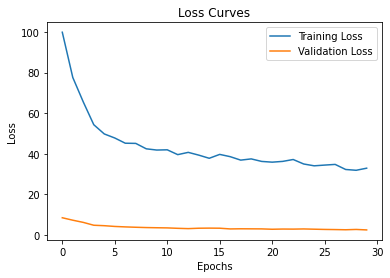

In [12]:
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')
plt.show()

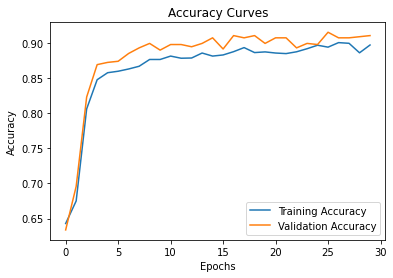

In [13]:
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accu, label='Training Accuracy')
plt.plot(validation_accu, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

# Testing

In [94]:
# # # #print("Calculating Training Accuracy")
# train_accuracy = Accuracy(res18,trainloader)
# print("Training Accuracy",train_accuracy[0])

# # print("Calculating Validation Accuracy")
# valid_accuracy = Accuracy(res18,validationloader)
# # print("Validation Accuracy",valid_accuracy[0])
# print(valid_accuracy[-1])

print("Calcualting Testing Results")
testloader = torch.utils.data.DataLoader(test_data, batch_size=629, shuffle=False, num_workers=4)
test_accuracy = Accuracy(res18,testloader)
print("covid patiens:", test_accuracy[0])
t_out = test_accuracy[-1]

report = []
for i in range(len(test_data.imgs)):
    label = (test_data.imgs[i][0].split('/')[-1])
    report.append([label,t_out[i][0],t_out[i][1],t_out[i][2]])
print("Creating CSV report")
import csv
with open('report_res18_without_focal_loss.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(report)

  0%|          | 0/1 [00:00<?, ?it/s]

Calcualting Testing Results


100%|██████████| 1/1 [00:11<00:00, 11.75s/it]

covid patiens: 0.0047694753577106515
Creating CSV report


In [0]:
def ConfusionMatrix(y_true,y_pred):
    for i in range(len(y_true)):
        y_true[i] = str(y_true[i])
        y_pred[i] = str(y_pred[i])
    #print("set: y_pred", set(y_pred))
    #print("set: y_true", set(y_true))
    from sklearn.metrics import confusion_matrix, classification_report
    print(confusion_matrix(y_true,y_pred))
    print("-----------------------------------------")
    print(classification_report(y_true,y_pred))


In [133]:
ConfusionMatrix(train_accuracy[1],train_accuracy[2])

[[   0    0    0    0    0    0    0]
 [  10 1702  283    3    0    0    2]
 [  13  119 3860    8    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   2   42  145    1    2    1    7]]
-----------------------------------------
                 precision    recall  f1-score   support

[0.0, 0.0, 0.0]       0.00      0.00      0.00         0
[0.0, 0.0, 1.0]       0.91      0.85      0.88      2000
[0.0, 1.0, 0.0]       0.90      0.96      0.93      4000
[0.0, 1.0, 1.0]       0.00      0.00      0.00         0
[1.0, 0.0, 0.0]       0.00      0.00      0.00         0
[1.0, 0.0, 1.0]       0.00      0.00      0.00         0
[1.0, 1.0, 0.0]       0.78      0.04      0.07       200

       accuracy                           0.90      6200
      macro avg       0.37      0.26      0.27      6200
   weighted avg       0.90      0.90      0.89      6200



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
ConfusionMatrix(valid_accuracy[1],valid_accuracy[2])

[[  0   0   0   0   0]
 [  2 178  20   0   0]
 [  0   6 393   1   0]
 [  0   0   0   0   0]
 [  1   1  26   0   0]]
-----------------------------------------
                 precision    recall  f1-score   support

[0.0, 0.0, 0.0]       0.00      0.00      0.00         0
[0.0, 0.0, 1.0]       0.96      0.89      0.92       200
[0.0, 1.0, 0.0]       0.90      0.98      0.94       400
[0.0, 1.0, 1.0]       0.00      0.00      0.00         0
[1.0, 1.0, 0.0]       0.00      0.00      0.00        28

       accuracy                           0.91       628
      macro avg       0.37      0.37      0.37       628
   weighted avg       0.88      0.91      0.89       628



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
